## Strategy

1) We will set a constant minimum daily rate (base_price) for up to 6 guests.

2) Every additional guest or pet will pay a constant price.

3) We will use a combination of the following functions to predict the pricing:
* Average Daily Rate (adr)
* Holidays in Peru (seasonality)
* Weekend premium
* Booking time in advance

4) As KPIs to measure success, we will monitor
* our weekly income to the Target weekly RevPAR

5) As monitored KPIs for potential future analysis, we will monitor:
* Occupancy rate

In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

import mplcursors

In [2]:
#ipympl enables 'matplotlib widget' for interactive widgets framework
%matplotlib widget

In [3]:
# Prices in PEN (Peruvial Soles), daily rate
base_price = 350
extra_guest = 50 
extra_pet = 50

In [4]:
# Import Airbnb RevPAR data of Chaclacayo - Peru
df_revPAR = pd.read_excel('seasonality_chacla.xlsx', sheet_name='RevPAR')
df_revPAR['Date'] = pd.to_datetime(df_revPAR['Date'])
df_revPAR['CW'] = df_revPAR['Date'].dt.isocalendar().week

# Normalize numeric values
df_revPAR['n_RevPAR']=(df_revPAR['RevPAR']-df_revPAR['RevPAR'].min())\
    /(df_revPAR['RevPAR'].max()-df_revPAR['RevPAR'].min())

df_revPAR.head()

,Date,RevPAR,Day,CW,n_RevPAR
0,2021-08-01,601,Sunday,30,0.672316
1,2021-08-02,520,Monday,31,0.557910
2,2021-08-03,508,Tuesday,31,0.540960
3,2021-08-04,534,Wednesday,31,0.577684
4,2021-08-05,540,Thursday,31,0.586158


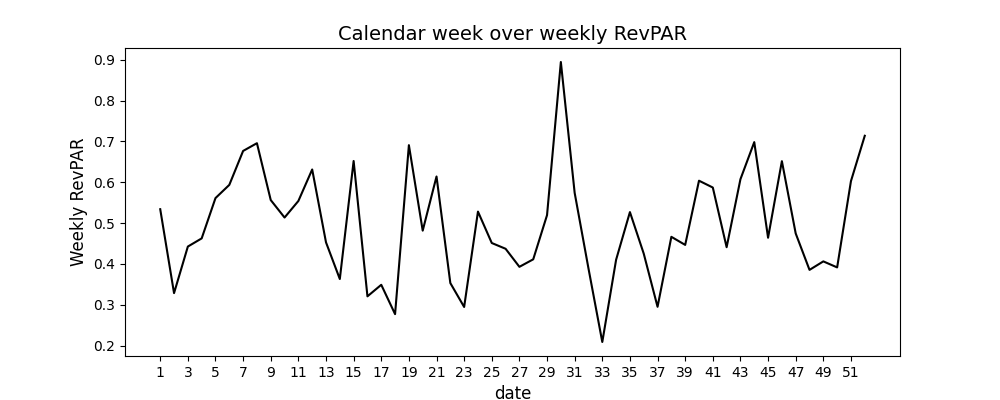

In [5]:
# Calculate aggregated RevPAR per Calendar Week
cw_df_revPAR = df_revPAR.groupby(df_revPAR.CW)['n_RevPAR'].sum()/7

# We plot RevPAR
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(cw_df_revPAR, color="black", label="n_RevPAR")
ax.set_xlabel("date", fontsize = 12)
ax.set_ylabel("Weekly RevPAR", color="black", fontsize=12)

temp = range(1,53,2);plt.xticks(temp);del temp
plt.title('Calendar week over weekly RevPAR', fontsize = 14)

mplcursors.cursor(hover=True) # Interacive

plt.show()

In [6]:
# Import National holidays in Peru
df_holidays = pd.read_excel('seasonality_chacla.xlsx', sheet_name='Holidays')
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])
df_holidays['CW'] = df_holidays['Date'].dt.isocalendar().week
#df_holidays['Importance'] = 0.0
df_holidays.head()

,Date,Holiday,Importance,CW
0,2021-08-30,Santa Rosa de Lima,0.0,35
1,2021-10-08,Combate Naval de Angamos,0.0,40
2,2021-11-01,Día de todos los Santos,0.0,44
3,2021-12-08,Inmaculada Concepción,0.0,49
4,2021-12-25,Navidad,0.0,51


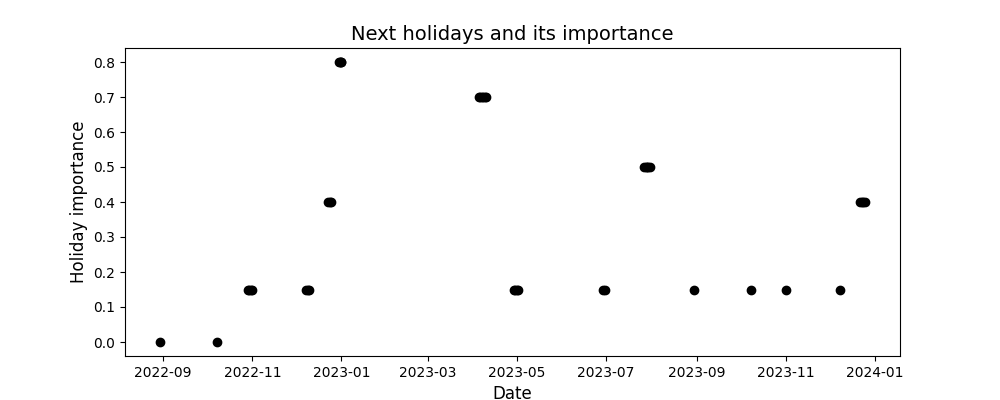

In [7]:
# Import National holidays in Peru
#df_holidays = pd.read_excel('seasonality_chacla.xlsx', sheet_name='Holidays')
#df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])
#df_holidays['CW'] = df_holidays['Date'].dt.isocalendar().week
#df_holidays['Importance'] = 0.0

# Put particular relevance in Holy Week, Independence Day, Christmas and New Year
#for index, row in df_holidays.iterrows():
#    if 'Jueves Santo' in row.Holiday:
#        df_holidays.loc[index, 'Importance'] = 0.25
#    if 'Viernes Santo' in row.Holiday:
#        df_holidays.loc[index, 'Importance'] = 0.25
#    if 'Resurrección' in row.Holiday:
#        df_holidays.loc[index, 'Importance'] = 0.25
#    if 'Fiestas Patrias' in row.Holiday:
#        df_holidays.loc[index, 'Importance'] = 0.5
#    if 'Fiestas Patrias' in row.Holiday:
#        df_holidays.loc[index, 'Importance'] = 0.5
#    if 'Navidad' in row.Holiday:
#        df_holidays.loc[index, 'Importance'] = 0.25
#    if 'Año Nuevo' in row.Holiday:
#        df_holidays.loc[index, 'Importance'] = 1
        
# Drop older holidays
df_holidays = df_holidays.drop(df_holidays[df_holidays.Date < '2022-08'].index)
df_holidays.reset_index(inplace=True)
df_holidays.drop(columns=['index'], inplace=True)

# We plot RevPAR
fig, ax = plt.subplots(figsize=(10, 4))

ax.scatter(df_holidays['Date'], df_holidays['Importance'], color="black", label="n_RevPAR")
ax.set_xlabel("Date", fontsize = 12)
ax.set_ylabel("Holiday importance", color="black", fontsize=12)

plt.title('Next holidays and its importance', fontsize = 14)

mplcursors.cursor(hover=True) # Interacive

plt.show()

In [8]:
# Import Airbnb Booking Lead Time - BLT
df_BLT = pd.read_excel('seasonality_chacla.xlsx', sheet_name='BLT')
df_BLT.rename(columns={"Booking_Lead_Time (days)": "BLT_days"}, inplace=True)
df_BLT['btl_Month'] = pd.to_datetime(df_BLT['Month']).dt.month
df_BLT.sort_values('btl_Month', inplace=True)
df_BLT.reset_index(inplace=True)
df_BLT.head(12)

,index,Month,BLT_days,btl_Month
0,5,2022-01,15,1
1,6,2022-02,16,2
2,7,2022-03,11,3
3,8,2022-04,19,4
4,9,2022-05,14,5
5,10,2022-06,15,6
6,11,2022-07,90,7
7,0,2021-08,18,8
8,1,2021-09,15,9
9,2,2021-10,16,10


In [9]:
# We create the function that will predict the prices for up to 2023

df = pd.DataFrame(columns=['Date', 'CW', 'Price'])
df['Date'] = pd.date_range(date(2022,9,1),date(2024,1,1)-timedelta(days=1),freq='d')
df['CW'] = df['Date'].dt.isocalendar().week

df['Price'] = base_price

for index, row in df.iterrows():   
    # Holiday effect - Special dates
    if not (df_holidays[df_holidays['Date']==row.Date.strftime('%Y-%m-%d')]['Importance']).empty:
        df.loc[index-1, 'Price'] = df.loc[index-1, 'Price'] + base_price * (df_holidays[df_holidays['Date']==row.Date.strftime('%Y-%m-%d')]['Importance']).iloc[0]
    # CW effect - Seasonality
    df.loc[index, 'Price'] = df.loc[index, 'Price'] + base_price * (cw_df_revPAR.iloc[row.CW-1]) *.5 # 0.5 to attenuate its effect
    
    # Weekend effect - 15% Premium
    if row.Date.day_name() == 'Friday' or row.Date.day_name() == 'Saturday':
        df.loc[index, 'Price'] = df.loc[index, 'Price'] * 1.15
    
    # Booking Lead Time discount
    #if (row.Date-pd.Timestamp.now()) < pd.Timedelta(10, "d"):
    #    df.loc[index, 'Price'] = df.loc[index, 'Price'] * .8
    #    if (row.Date-pd.Timestamp.now()) < pd.Timedelta(5, "d"):
    #        df.loc[index, 'Price'] = df.loc[index, 'Price'] * .8
    
    # Prevents dropping below base_price
    if df.loc[index, 'Price'] < base_price:
        df.loc[index, 'Price'] = base_price


        Date  CW       Price
0 2022-09-01  35  442.231638
1 2022-09-02  35  508.566384
2 2022-09-03  35  508.566384
3 2022-09-04  35  442.231638
4 2022-09-05  36  424.435028


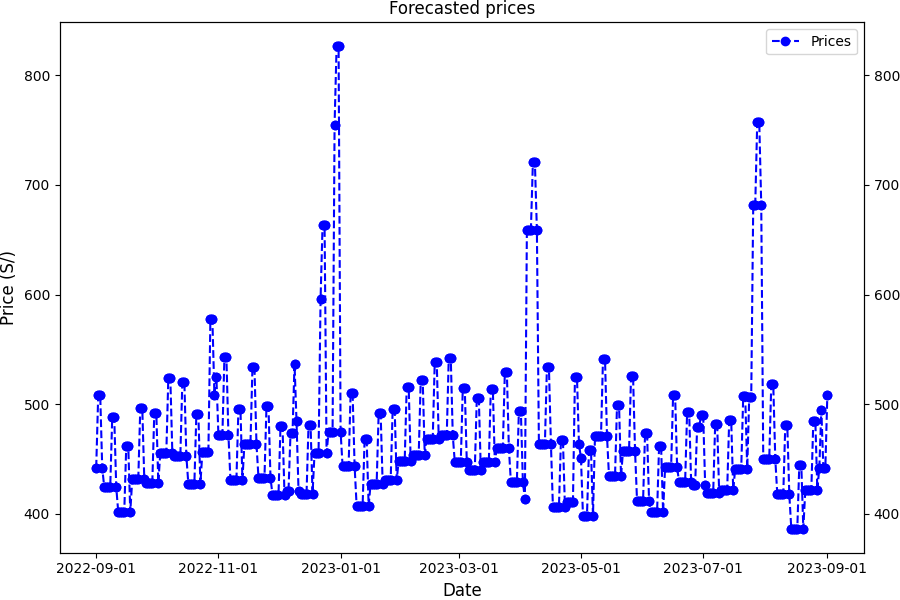

In [10]:
# Drop values too far into the future
df = df.drop(df[df.Date > '2023-09'].index)

print(df.head())
import matplotlib.dates as mdates

# We plot
fig, ax = plt.subplots(figsize=(9, 6))

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False

ax.scatter(df['Date'], df['Price'], color="blue", label="Prices")
ax2=ax.twinx()
ax2.plot(df['Date'], df['Price'], '--o', color="blue", label="Prices")

ax.set_xlabel("Date", fontsize = 12)
ax.set_ylabel("Price (S/)", color="black", fontsize=12)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title('Forecasted prices', fontsize = 12)
plt.legend()
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)

mplcursors.cursor(ax,hover=True) # Interacive

plt.show()

In [11]:
#df.head(180)
for index, row in df.iterrows():   
    print(row.Date.strftime('%Y-%m-%d'), " ", round(row.Price))

2022-09-01   442
2022-09-02   509
2022-09-03   509
2022-09-04   442
2022-09-05   424
2022-09-06   424
2022-09-07   424
2022-09-08   424
2022-09-09   488
2022-09-10   488
2022-09-11   424
2022-09-12   402
2022-09-13   402
2022-09-14   402
2022-09-15   402
2022-09-16   462
2022-09-17   462
2022-09-18   402
2022-09-19   432
2022-09-20   432
2022-09-21   432
2022-09-22   432
2022-09-23   496
2022-09-24   496
2022-09-25   432
2022-09-26   428
2022-09-27   428
2022-09-28   428
2022-09-29   428
2022-09-30   492
2022-10-01   492
2022-10-02   428
2022-10-03   456
2022-10-04   456
2022-10-05   456
2022-10-06   456
2022-10-07   524
2022-10-08   524
2022-10-09   456
2022-10-10   453
2022-10-11   453
2022-10-12   453
2022-10-13   453
2022-10-14   521
2022-10-15   521
2022-10-16   453
2022-10-17   427
2022-10-18   427
2022-10-19   427
2022-10-20   427
2022-10-21   491
2022-10-22   491
2022-10-23   427
2022-10-24   456
2022-10-25   456
2022-10-26   456
2022-10-27   456
2022-10-28   577
2022-10-29   5